# Day 4: Protein Mix Debug

In [1]:
from cdk.analysis.cytosol import platereader as pr

# Initialize plotting
pr.plot_setup()

# Load the data

Provide a CSV file containing the data, and a platemap. This function returns both the data with the plate map mapped to it, and the platemap by itself, which is useful for certain tasks.

In [4]:
data_path = "/home/jovyan/work/shared/nucleus-pure-workshop/2025050515-OPWS-day4/2-data/20250514-211604-pure-timecourse-gfp-nucleus-pure-workshop-day3-protein-mix-debug-biotek-cdk.txt"
platemap_path = "/home/jovyan/work/shared/nucleus-pure-workshop/2025050514-OPWS-day3/1-design/20250514-OPWS-blueteam.tsv"

data, platemap = pr.load_platereader_data(data_path, platemap_path)

In [5]:
data.head()

,index,Time,Well,Data,Row,Column,Read,Sample #,Type,Name,ArgRS,T7 RNAP,IF2,EF-TU,T7 RNAP (ctrl),ArgRS (ctrl),IF2 (ctrl),EF-TU (ctrl),plamGFP (ug/uL)
0,3190,0 days 00:02:00,B2,44,B,2,GFP-Gext,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3191,0 days 00:07:00,B2,45,B,2,GFP-Gext,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3192,0 days 00:12:00,B2,50,B,2,GFP-Gext,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3193,0 days 00:17:00,B2,83,B,2,GFP-Gext,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3194,0 days 00:22:00,B2,118,B,2,GFP-Gext,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
platemap

,Well,Sample #,Type,Name,ArgRS,T7 RNAP,IF2,EF-TU,T7 RNAP (ctrl),ArgRS (ctrl),IF2 (ctrl),EF-TU (ctrl),plamGFP (ug/uL)
0,B2,1,Control,NEB +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B3,2,Control,NEB -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B4,3,Control,OP +,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B5,4,Control,OP -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B6,5,Control,Ribo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,K8,99,Standard,plamGFP-75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.00
105,K10,100,Standard,plamGFP-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
106,K12,101,Standard,plamGFP-125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.00
107,K14,102,Standard,plamGFP-150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.00


In [5]:
data.fillna(0, inplace=True)
data["Total Spike"] = data.iloc[:,10:-1].sum(axis=1)
data["Total Spike"].unique()

array([0. , 1. , 1.5, 0.5, 2. ])

In [6]:
proteins = data.columns[10:-3]

# Basic Plots

## Timecourses 
Time traces of every well on the plate

In [7]:
# Remove the standards from the dataset, we don't want to see them and aren't going to use them here.
data = data[data["Type"] != "Standard"]

## By sample type
Split up the plots by sample type, so that the controls don't overwhelm our samples. We set `sharey` to `False` so that each plot gets its own Y axis based on the data.

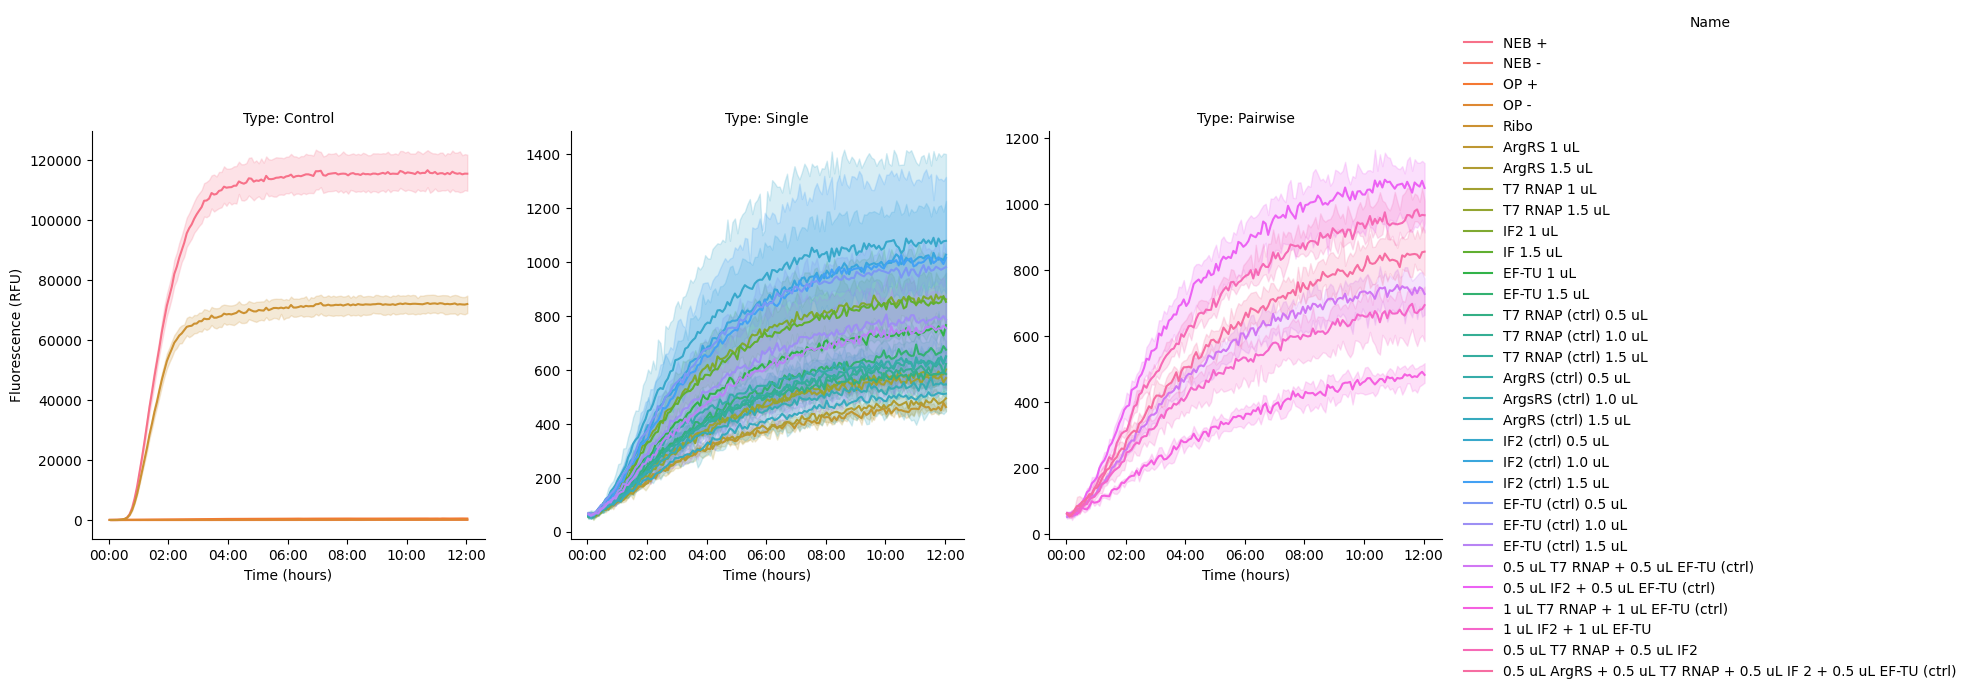

In [8]:
#| label: fig:day4-kinetics
pr.plot_curves(data, col="Type", facet_kws={ "sharey": False })

## Spike volume
Plot by the total volume of spike protein added. This will help us see whether the total volume is affecting performance. For instance, adding more spike protein also implies adding more protein storage buffer, which will affect the buffering conditions--magnesium, etc.

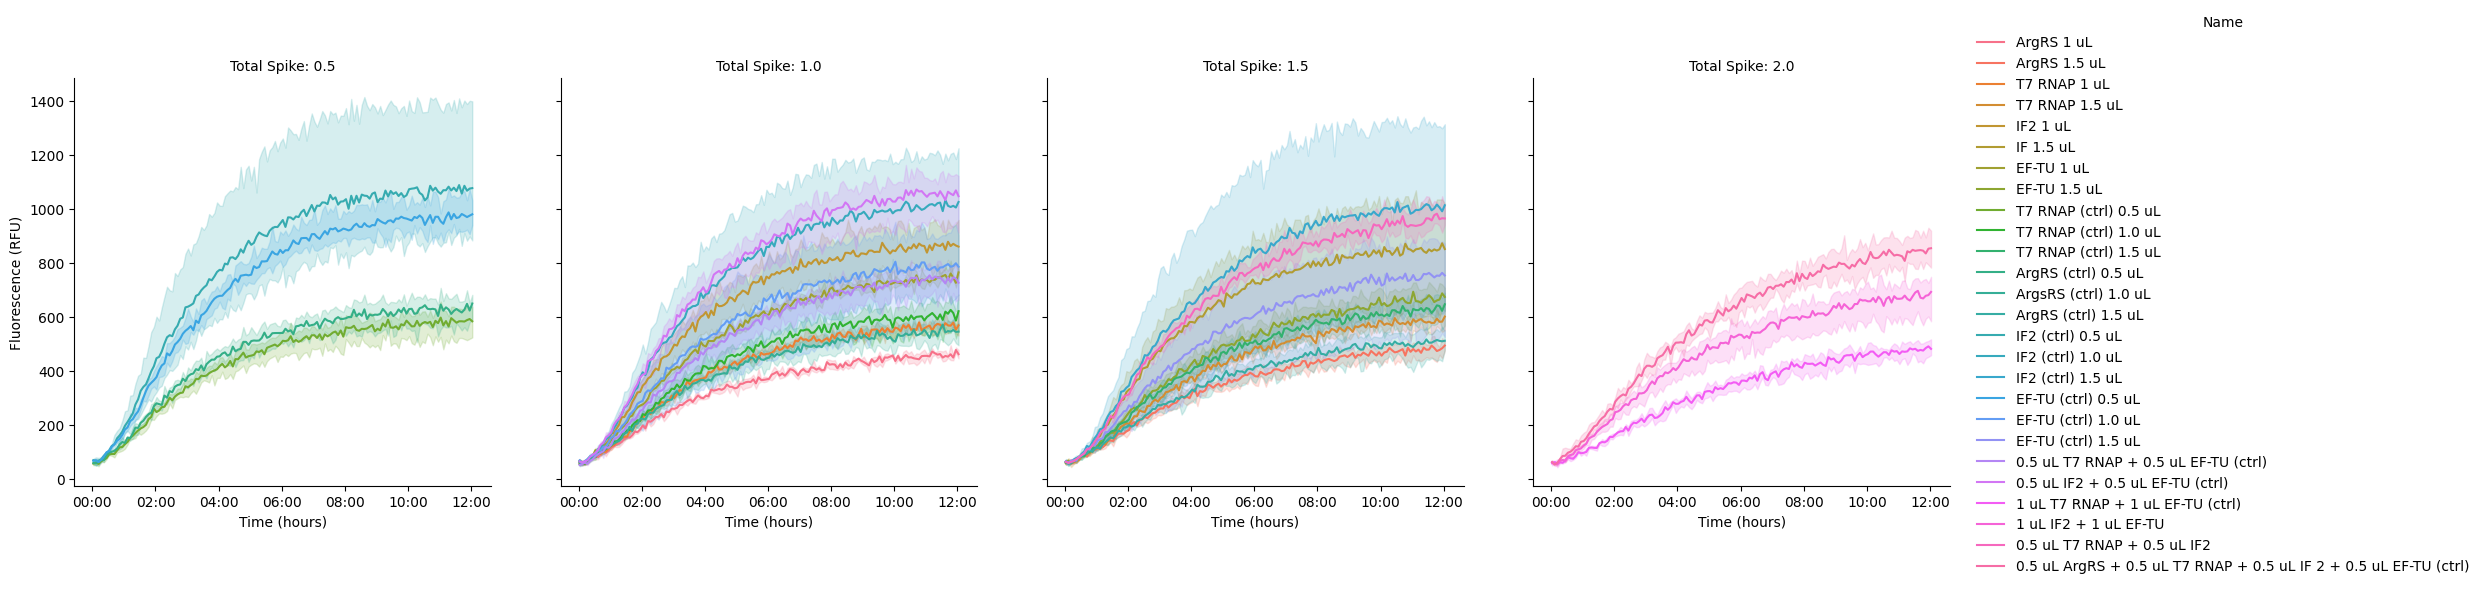

In [25]:
# We share the y axis here so that we can compare the differences directly.
pr.plot_curves(data[data["Type"] != "Control"], col="Total Spike", facet_kws={ "sharey": True })

If it's hard to see what's going on because of the error bars, we can disable them:

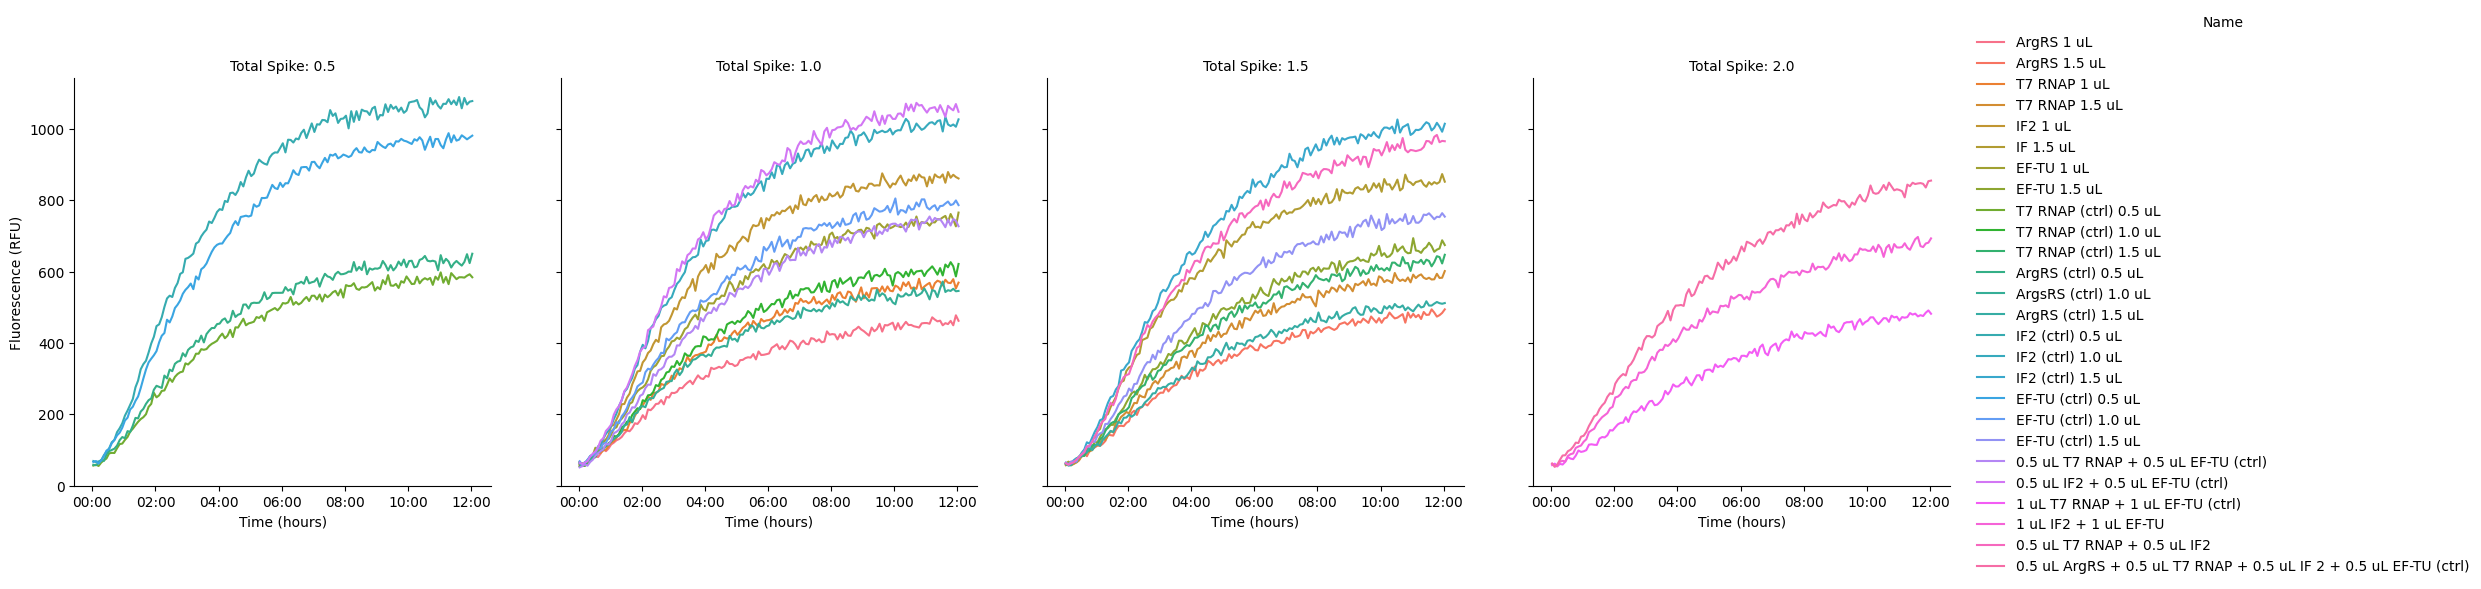

In [27]:
# We share the y axis here so that we can compare the differences directly.
pr.plot_curves(data[data["Type"] != "Control"], col="Total Spike", errorbar=None, facet_kws={ "sharey": True })

Cool! It doesn't look like there's a profound difference, but perhaps the samples with 2 uL of total spike protein are a little lower (though there's only a few of them, so maybe we just don't have enough of a range.

## Per Protein

Let's look at each protein separately. First, we'll use the volume information to create a new column indicating what proteins are in which column. This uses some trickier python and pandas, so bear with us.

We could also have just labelled this directly in the platemap (we pretty much did by name), and we also could have parsed it out of there. Sometimes it's useful to be able to add to the platemap directly in python, however.

In [12]:
data["Spikes"] = data.loc[:,proteins].agg(lambda x: ",".join([ col for col in x.index if x[col] > 0 ]), axis=1)
data[data["Spikes"] != ""].head() # Look at some that aren't empty

,index,Time,Well,Data,Row,Column,Read,Sample #,Type,Name,...,T7 RNAP,IF2,EF-TU,T7 RNAP (ctrl),ArgRS (ctrl),IF2 (ctrl),EF-TU (ctrl),plamGFP (ug/uL),Total Spike,Spikes
725,4060,0 days 00:02:00,B8,51,B,8,GFP-Gext,6,Single,ArgRS 1 uL,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,ArgRS
726,4061,0 days 00:07:00,B8,55,B,8,GFP-Gext,6,Single,ArgRS 1 uL,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,ArgRS
727,4062,0 days 00:12:00,B8,53,B,8,GFP-Gext,6,Single,ArgRS 1 uL,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,ArgRS
728,4063,0 days 00:17:00,B8,59,B,8,GFP-Gext,6,Single,ArgRS 1 uL,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,ArgRS
729,4064,0 days 00:22:00,B8,70,B,8,GFP-Gext,6,Single,ArgRS 1 uL,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,ArgRS


In [13]:
# What are all the different spike labels we have?
data["Spikes"].unique()

array(['', 'ArgRS', 'T7 RNAP', 'IF2', 'EF-TU', 'T7 RNAP (ctrl)',
       'ArgRS (ctrl)', 'IF2 (ctrl)', 'IF2,EF-TU', 'T7 RNAP,IF2',
       'ArgRS,T7 RNAP,IF2'], dtype=object)

Now we can take a look using the new label. We'll have the volumes added across the columns, and the proteins added down the rows.

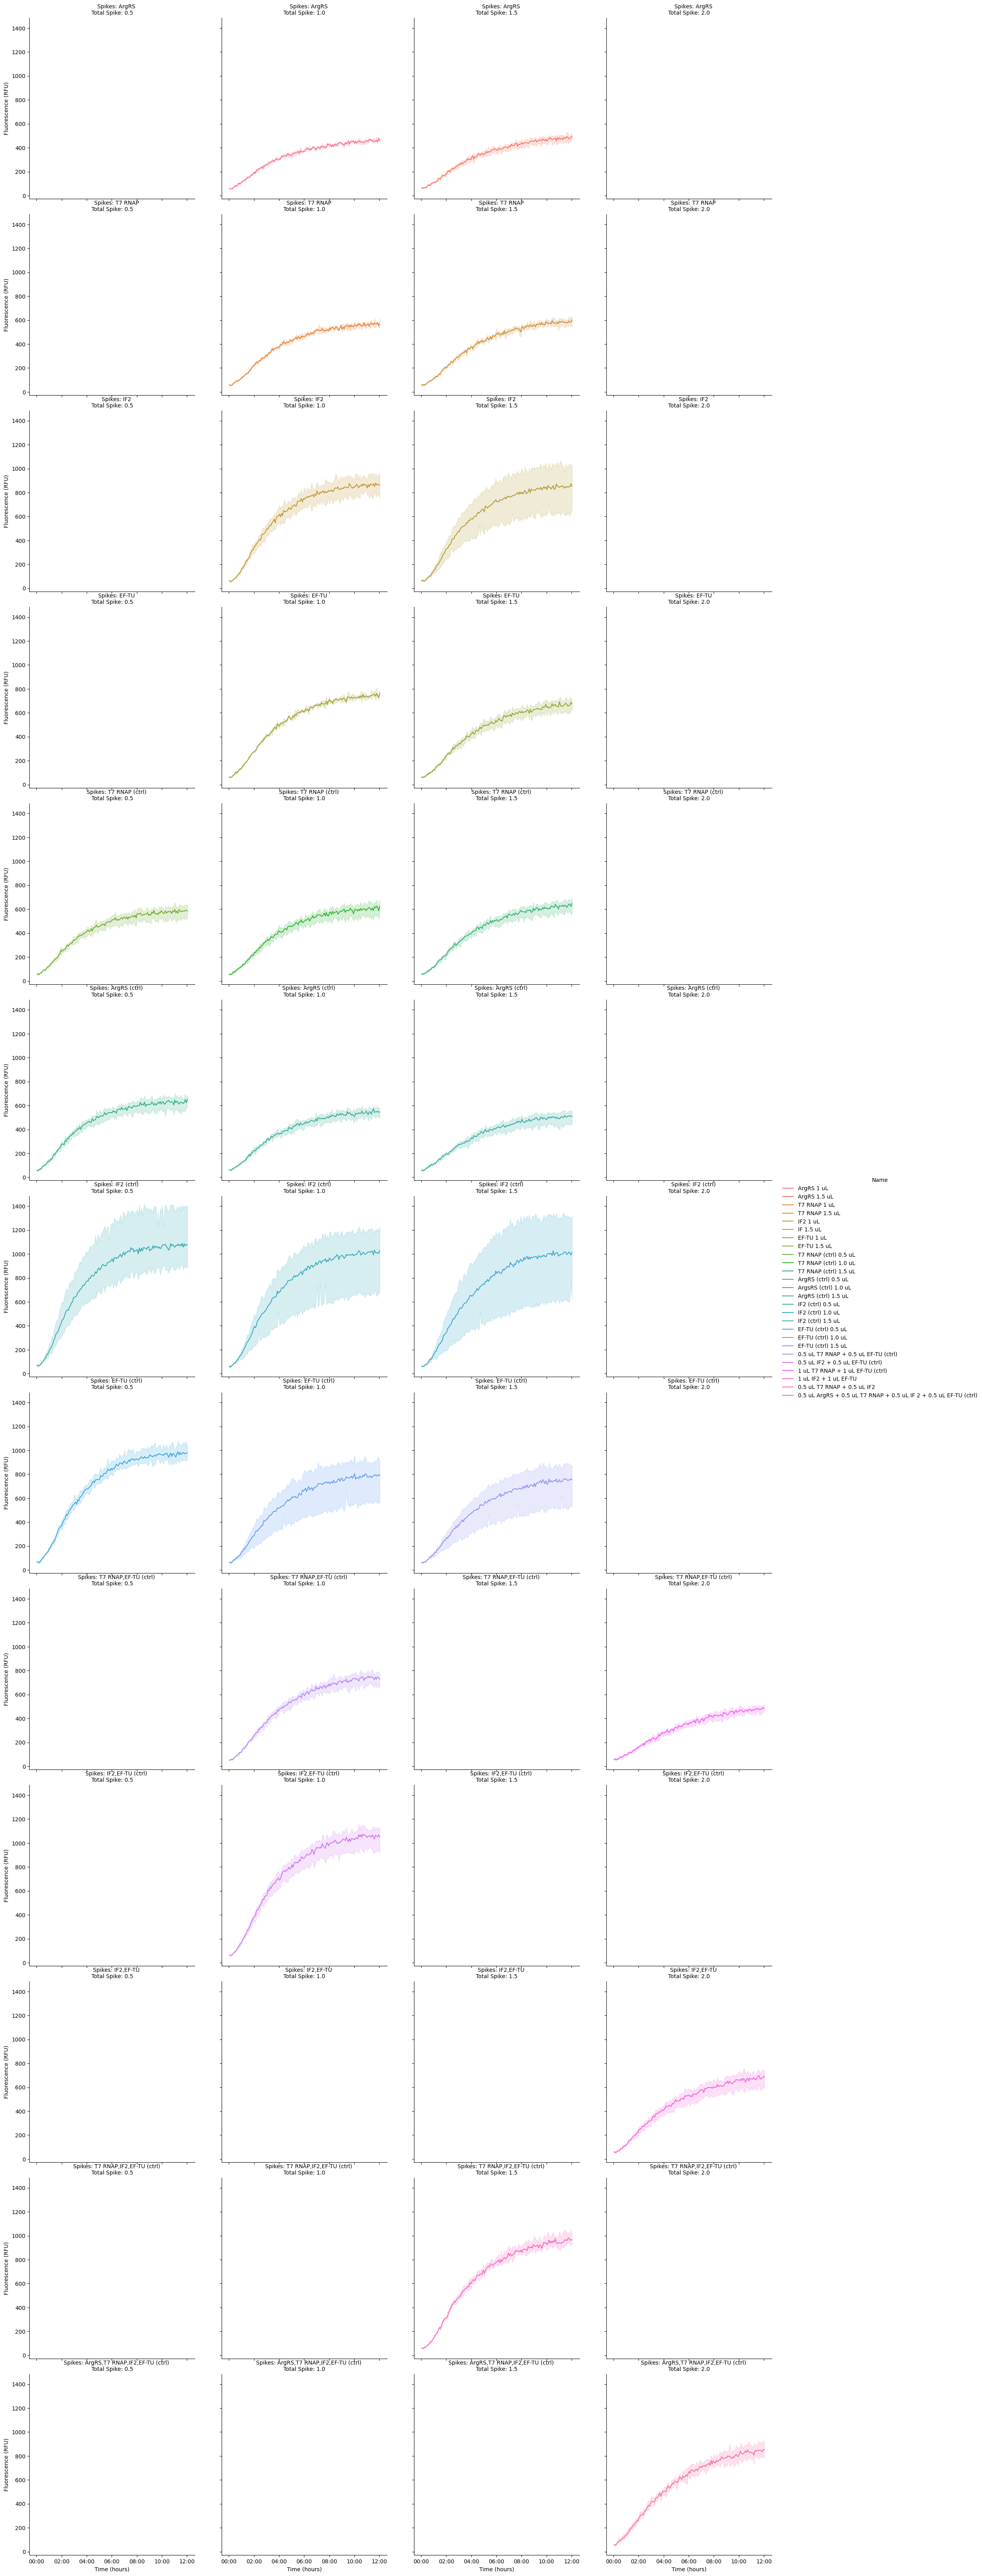

In [93]:
pr.plot_curves(data[data["Type"] != "Control"], col="Total Spike", row="Spikes", facet_kws={ "sharey": True })

## Steady state
Bar graph of steady-state endpoint of each sample. Steady state is calculated as the maximum fluorescence value over a 3-sample rolling average on the data.

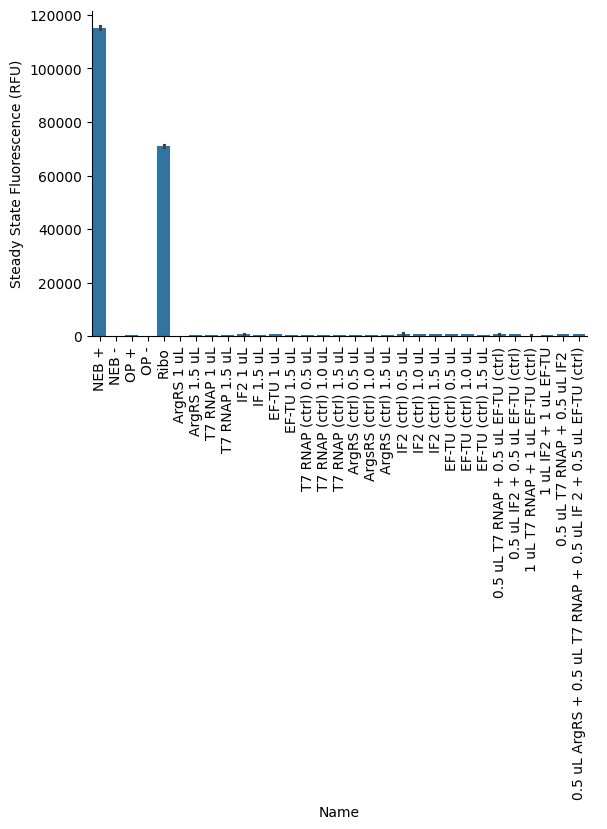

In [9]:
pr.plot_steadystate(data)

Get rid of the controls because they make us sad.

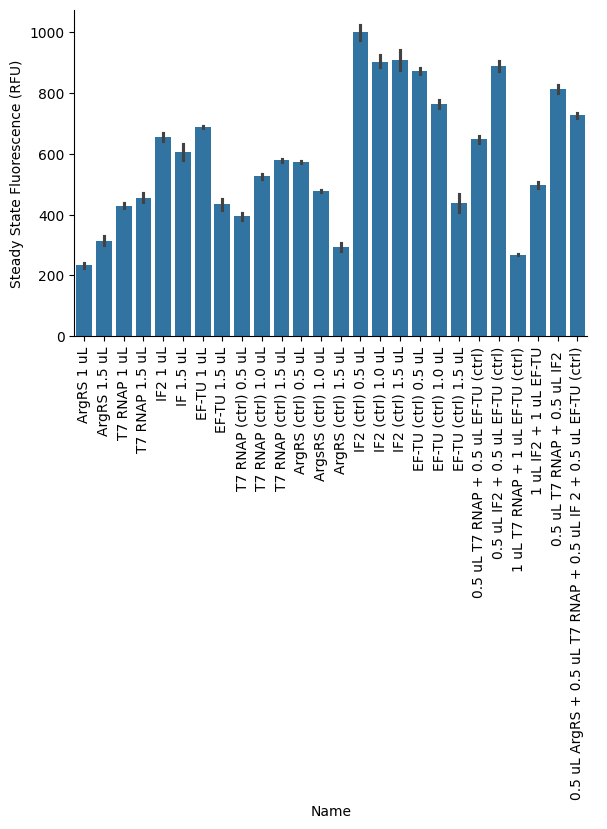

In [8]:
pr.plot_steadystate(data[data["Type"] != "Control"])

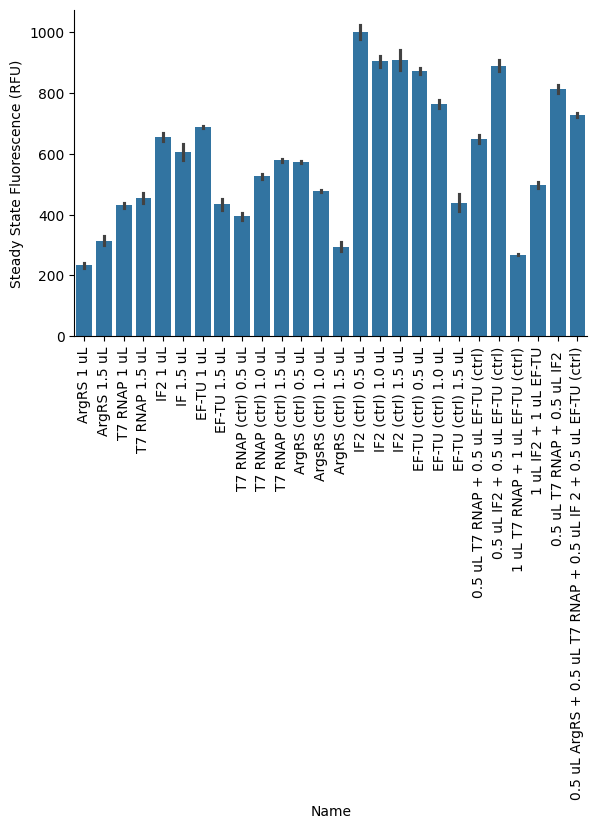

In [14]:
pr.plot_steadystate(data[data["Type"] != "Control"])

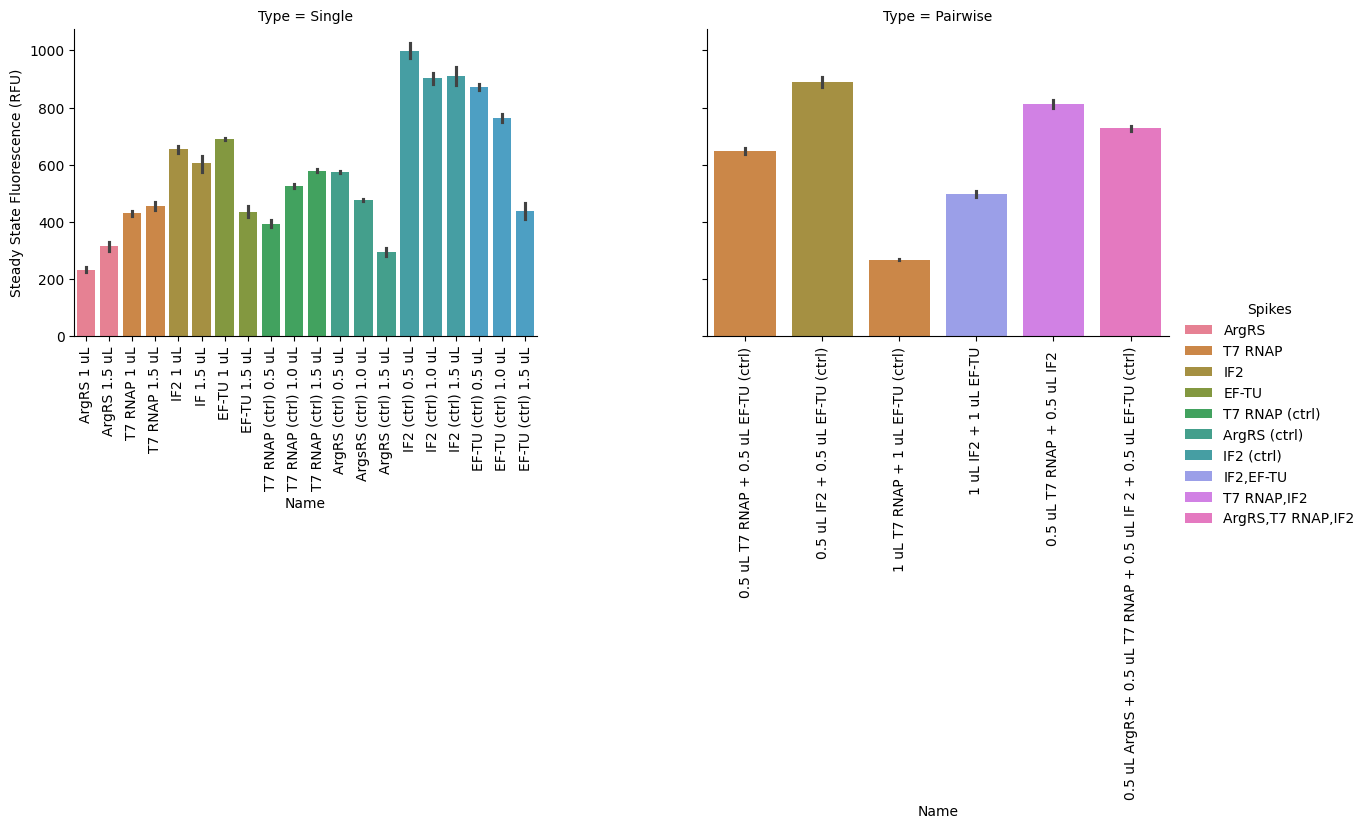

In [15]:
pr.plot_steadystate(data[data["Type"] != "Control"], hue="Spikes", col="Type")

# Kinetics Analysis
These functions calculate key kinetic parameters of the time series.

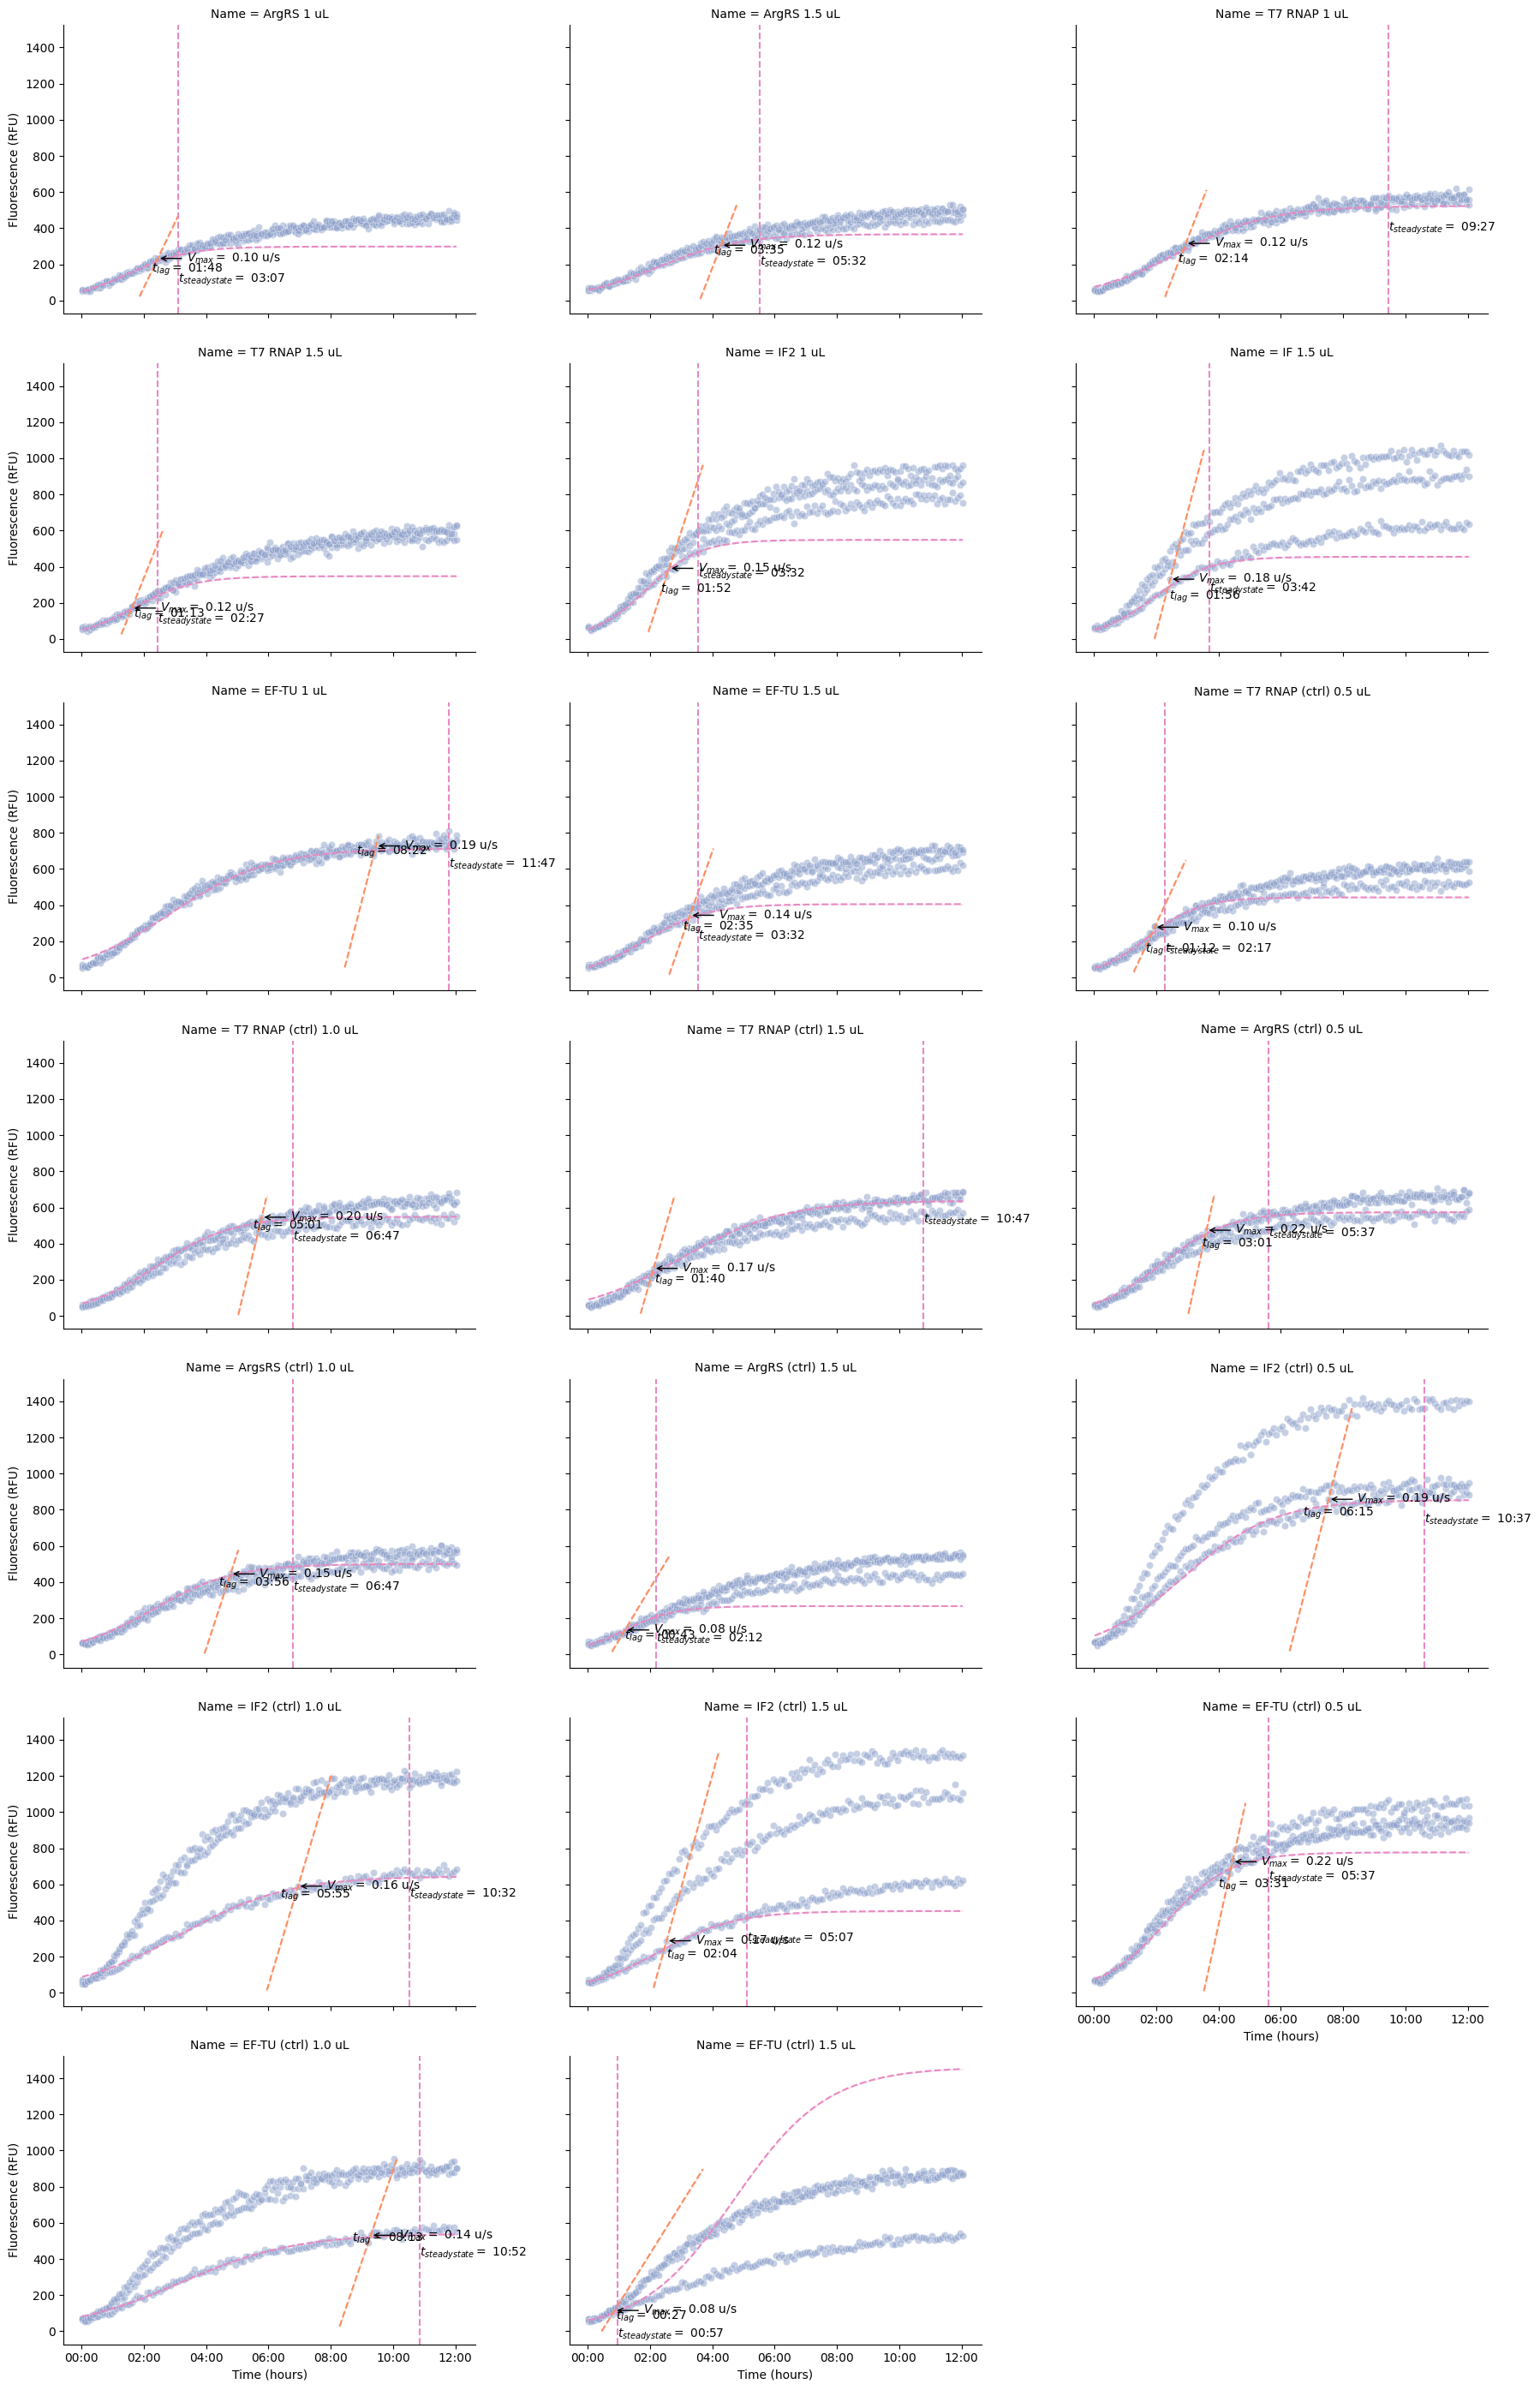

In [16]:
pr.plot_kinetics(data[data["Type"] == "Single"])

We can also calculate the kinetics and display the parameters as a table.

In [25]:
pr.kinetic_analysis(data)

Velocity              \
                                            Time   Data  Max   
Well Name          Read                                        
B1   pT7-deGFP 100 485/20,528/20 0 days 00:05:00   6.00 0.02   
B2   pT7-deGFP 50  485/20,528/20 0 days 00:15:00  28.00 0.04   
B3   pT7-deGFP 20  485/20,528/20 0 days 00:05:00   6.00 0.02   
B4   pT7-deGFP 10  485/20,528/20 0 days 00:35:00 220.00 0.17   
B5   pT7-deGFP 5   485/20,528/20 0 days 00:05:00   6.00 0.02   
B6   pT7-deGFP 2   485/20,528/20 0 days 00:15:00  19.00 0.03   
B7   pT7-deGFP 1   485/20,528/20 0 days 00:05:00   5.00 0.01   
B8   pT7-deGFP 0   485/20,528/20 0 days 00:50:00 156.00 0.08   

                                                       Lag        \
                                                      Time  Data   
Well Name          Read                                            
B1   pT7-deGFP 100 485/20,528/20         -1 days +23:59:00  0.00   
B2   pT7-deGFP 50  485/20,528/20 0 days 00:04:13.846153846  0.00   
B3   pT7-deGFP 20  485/20,528/20         -1 days +23:59:00  0.00   
B4   pT7-deGFP 10  485/20,528/20 0 days 00:13:25.882352941  0.00   
B5   pT7-deGFP 5   485/20,528/20         -1 days +23:59:00  0.00   
B6   pT7-deGFP 2   485/20,528/20 0 days 00:04:26.666666667 13.38   
B7   pT7-deGFP 1   485/20,528/20         -1 days +23:58:45  0.00   
B8   pT7-deGFP 0   485/20,528/20 0 days 00:16:05.217391304  0.00   

                                    Steady State           Fit               
                                            Time   Data      L    k      x0  
Well Name          Read                                                      
B1   pT7-deGFP 100 485/20,528/20 0 days 00:25:00   6.00   0.00 0.00    0.00  
B2   pT7-deGFP 50  485/20,528/20 0 days 02:40:00 132.00   0.00 0.00    0.00  
B3   pT7-deGFP 20  485/20,528/20 0 days 00:20:00   6.00   0.00 0.00    0.00  
B4   pT7-deGFP 10  485/20,528/20 0 days 02:45:00 679.00   0.00 0.00    0.00  
B5   pT7-deGFP 5   485/20,528/20 0 days 00:20:00   6.00   0.00 0.00    0.00  
B6   pT7-deGFP 2   485/20,528/20 0 days 02:35:00 108.00 106.53 0.00 2482.26  
B7   pT7-deGFP 1   485/20,528/20 0 days 00:20:00   5.00   0.00 0.00    0.00  
B8   pT7-deGFP 0   485/20,528/20 0 days 02:30:00 310.00   0.00 0.00    0.00